In [ ]:
from fastai.vision.all import *
from drone_detector.tiling import *
from drone_detector.visualizations import *
from drone_detector.metrics import *
from drone_detector.augmentations import *
from drone_detector.segmentation import *
from drone_detector.multichannel import *
import albumentations as A
from icevision.all import *

In [ ]:
class RegressionMask(TensorMask):
    _show_args = ArrayImage._show_args

    def show(self, ctx=None, **kwargs):
        if 'channels' in kwargs.keys(): kwargs.pop('channels')
        return super().show(ctx=ctx, **kwargs)

    @classmethod
    def create(cls, fn:(Path,str,ndarray), **kwargs) ->None:
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray):
            im = torch.from_numpy(fn)
            return cls(im)
        if isinstance(fn, Path) or isinstance(fn, str):
            if str(fn).endswith('npy'): return cls(open_npy(fn=fn))
            elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn))
            
RegressionMask.create = Transform(RegressionMask.create) 

def RegressionMaskBlock(cls=RegressionMask, **kwargs): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create))

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    "A transform handler for `Albumentation` transforms. "
    split_idx = 0

    def __init__(self, aug, im_cls=PILImage, mask_cls=PILMask): store_attr()

    def encodes(self, x):
        img, mask = x
        img = np.array(img).transpose(1, 2, 0)

        aug = self.aug(image=img, mask=np.array(mask[0]))

        return (self.im_cls.create(aug['image'].copy().transpose(2,0,1)), 
               self.mask_cls.create(aug['mask'][None].copy()))

# Train model

In [ ]:
transform_list = [A.ToFloat(max_value=10000.0, always_apply=True),
                  A.RandomBrightnessContrast(p=0.5,brightness_limit=.05, brightness_by_max=True),
                  A.RandomRotate90(p=0.5),
                  A.HorizontalFlip(p=.5),
                  A.VerticalFlip(p=.5),
                  A.CoarseDropout(),
                  A.FromFloat(max_value=10000.0, dtype=np.float32, always_apply=True)
                  #A.Blur(p=.1)
                 ]

In [ ]:
used_tfms =  SegmentationAlbumentationsTransform(A.Compose(transform_list), 
                                                 im_cls=MultiChannelTensorImage, 
                                                 mask_cls=RegressionMask)

In [ ]:
path = Path('data/patches/')
month = 'june'
fnames = [path/f'{month}_2018/{f}' for f in os.listdir(path/f'{month}_2018') if f.endswith('.tif')]

stats = np.array([[340.76769064, 429.9430203, 614.21682446, 590.23569706, 950.68368468, 1792.46290469,
                  2075.46795189, 2218.94553375, 2266.46036911, 2246.0605464, 1594.42694882, 1009.32729131],
                  [554.81258967, 572.41639287, 582.87945694, 675.88746967,729.89827633,1096.01480586, 1273.45393088,
                   1365.45589904, 1356.13789355, 1302.3292881, 1079.19066363, 818.86747235]]) 

segm = TifSegmentationDataLoaders.from_label_func(path/f'{month}_2018', fnames, y_block=RegressionMaskBlock,
                                                  label_func=partial(label_with_matching_fname, 
                                                                     path=path/'pine_tiles'),
                                                  batch_tfms = [Normalize.from_stats(*stats)],
                                                  item_tfms = [used_tfms], seed=321, valid_pct=0.3,
                                                  bs=8)


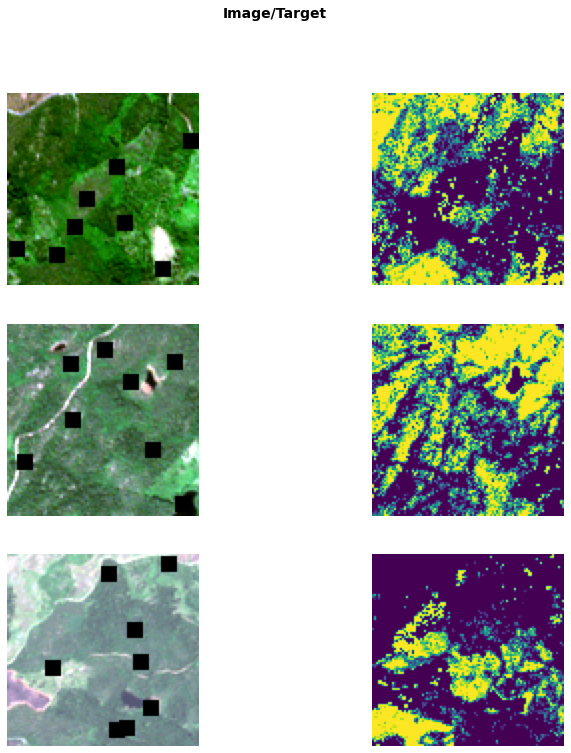

In [ ]:
segm.show_batch(channels=[3,2,1])

In [ ]:
learn = unet_learner(segm, resnet101, pretrained=False, n_in=12, n_out=1, loss_func=MSELossFlat(), metrics=[rmse, mae],
                     config={'y_range': (0,1), 'blur_final':False, 'self_attention': True, 'blur':False})


In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.181079,0.167875,0.409726,0.383907,00:09
1,0.174097,0.159462,0.399326,0.368957,00:03
2,0.168876,0.142635,0.377671,0.337109,00:03
3,0.166468,0.144815,0.380546,0.332428,00:03
4,0.162255,0.131270,0.362313,0.306291,00:03
5,0.158344,0.135475,0.368069,0.320884,00:03
6,0.155320,0.141971,0.376790,0.310583,00:03
7,0.150566,0.118225,0.343838,0.291363,00:04
8,0.145333,0.117546,0.342850,0.281036,00:03
9,0.142500,0.123303,0.351145,0.290900,00:03


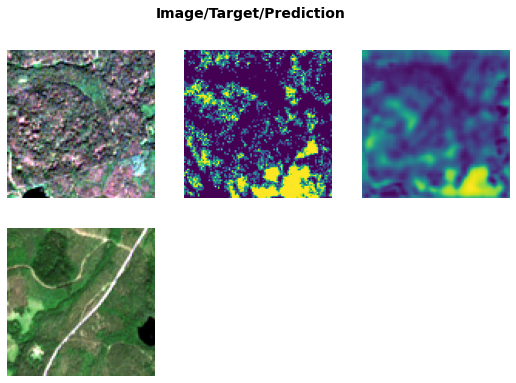

In [ ]:
learn.show_results(max_n=4, channels=[3,2,1])

In [ ]:
preds = learn.get_preds(with_input=True, with_decoded=True, ds_idx=1)

preds[3].numpy().min(), preds[3].numpy().max()

(9.678943e-05, 0.98686)

In [ ]:
@delegates(subplots)
def get_grid(n, nrows=None, ncols=None, add_vert=0, figsize=None, double=False, title=None, return_fig=False, 
             flatten=True, **kwargs):
    "Return a grid of `n` axes, `rows` by `cols`"
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    if double: ncols*=2 ; n*=2
    fig,axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    if flatten: axs = [ax if i<n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    if title is not None: fig.suptitle(title, weight='bold', size=14)
    return (fig,axs) if return_fig else axs

In [ ]:
class SegmentationRegressionInterpretation(Interpretation):
    
    def __init__(self, dl, inputs, preds, targs, decoded, losses): store_attr()
        
    def top_mae(self, k=None, largest=True):
        return torch.abs(self.preds-self.targs).mean(axis=(1,2,3)).topk(ifnone(k, len(self.preds)), largest=largest)
        
    def plot_top_mae(self, k, largest=True, **kwargs):
        pass

@typedispatch
def plot_top_losses(x:TensorImage, y:TensorMask, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axes = get_grid(len(samples)*3, nrows=len(samples), ncols=3, add_vert=1, figsize=figsize, flatten=False, title="Input | Target | Prediction")
    if axes.ndim == 1:  axes = (axes,)
    titles = ["input", "target", "pred"]
    for axs,s,o,l in zip(axes, samples, outs, losses):
        imgs = (s[0], s[1], o[0])
        for ax,im,title in zip(axs, imgs, titles):
            if title=="pred": title += f"; loss = {l:.4f}"
            im.show(ctx=ax, **kwargs)
            ax.set_title(title)

In [ ]:
interp = SegmentationRegressionInterpretation.from_learner(learn)

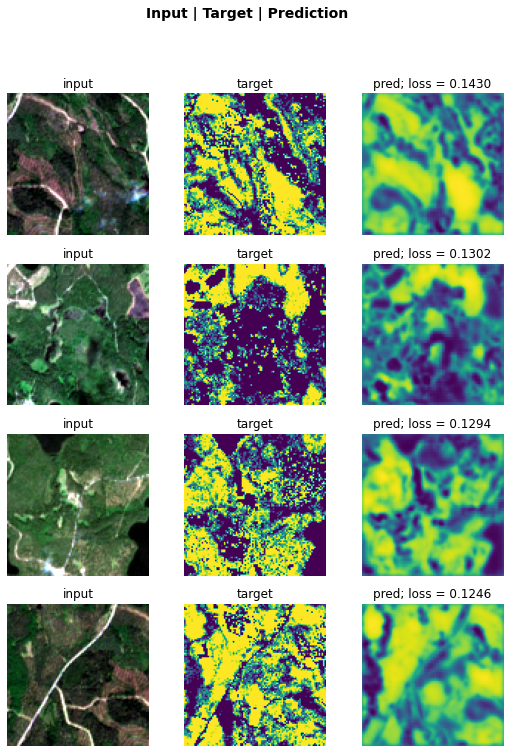

In [ ]:
interp.plot_top_losses(4, channels=[3,2,1])

In [ ]:
#export

from matplotlib.cm import ScalarMappable

@typedispatch
def show_results(x:TensorImage, y:TensorMask, samples, outs, ctxs, max_n=6,
                 nrows=None, ncols=3, figsize=None, show_cbar=False, **kwargs):
    "Patch `show_results` to show segmentation results in three columns (no-mask, ground truth, prediction)"
    
    
    if ctxs is None: ctxs = get_grid(min(len(samples)*3, max_n*3), nrows=int(min(len(samples), max_n)), 
                                     ncols=3, add_vert=1, figsize=figsize, double=False, 
                                     title='Image/Target/Prediction')
        
    for i in range(2):
        ctxs[::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0), ctxs[::3],range(3*max_n))]
        ctxs[1::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i), ctxs[1::3],range(2*max_n))]
    
    for o in [samples,outs]:
        ctxs[2::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(o.itemgot(0),ctxs[2::3], range(2*max_n))]
    
    if isinstance(y, RegressionMask) and show_cbar:
        ctxs[1::3] = [plt.colorbar(ScalarMappable(cmap='viridis'), ax=c) for c, _ in zip(ctxs[1::3], range(2*max_n))]
        ctxs[2::3] = [plt.colorbar(ScalarMappable(cmap='viridis'), ax=c) for c, _ in zip(ctxs[2::3], range(2*max_n))]

    return ctxs

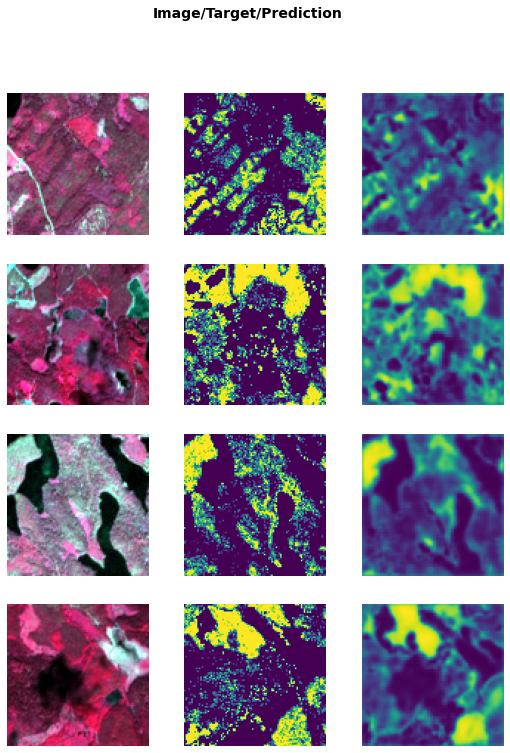

In [ ]:
learn.show_results(max_n=4, channels=[7,3,2])

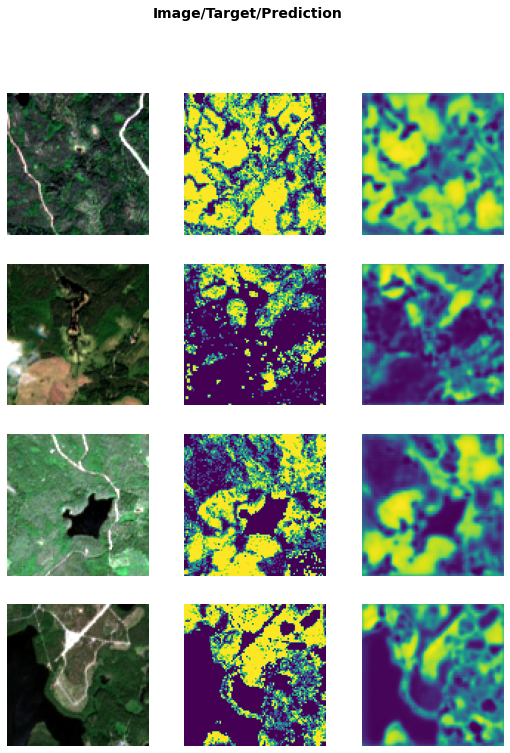

In [ ]:
learn.show_results(max_n=4, channels=[3,2,1], show_cbar=False)

# Predict full July tile

In [ ]:
from drone_detector.tiling import *
from drone_detector.utils import *
from osgeo import gdal
from shutil import rmtree

In [ ]:
path_to_image = 'data/resampled_tiffs/june_big_2018.tif'

In [ ]:
processing_dir = 'temp'
tile_size = 512
tile_overlap = 0
outfile = 'june_pine_big.tif'

In [ ]:
os.makedirs(processing_dir)
print(f'Reading and tiling {path_to_image} to {tile_size}x{tile_size} tiles with overlap of {tile_overlap}px')
tiler = Tiler(outpath=processing_dir, gridsize_x=int(tile_size), gridsize_y=int(tile_size), 
              overlap=(int(tile_overlap), int(tile_overlap)))
tiler.tile_raster(path_to_image)


test_files = get_image_files(f'{processing_dir}/raster_tiles')
print('Starting prediction')
os.makedirs(f'{processing_dir}/predicted_rasters')
for chunk in range(0, len(test_files), 100):
    test_dl = learn.dls.test_dl(test_files[chunk:chunk+100], num_workers=0, bs=1)
    preds = learn.get_preds(dl=test_dl)[0]

    print('Rasterizing predictions')
    for f, p in tqdm(zip(test_files[chunk:chunk+100], preds)):
        ds = gdal.Open(str(f))
        out_raster = gdal.GetDriverByName('gtiff').Create(f'{processing_dir}/predicted_rasters/{f.stem}.{f.suffix}',
                                                          ds.RasterXSize,
                                                          ds.RasterYSize,
                                                          1, gdal.GDT_Int16)
        out_raster.SetProjection(ds.GetProjectionRef())
        out_raster.SetGeoTransform(ds.GetGeoTransform())
        np_pred = p.numpy()[0] * 255
        band = out_raster.GetRasterBand(1).WriteArray(np_pred.astype(np.int))
        band = None
        out_raster = None
        ds = None

print('Merging predictions')
untile_raster(f'{processing_dir}/predicted_rasters', outfile=outfile)

print('Removing intermediate files')
rmtree(processing_dir)

Reading and tiling data/resampled_tiffs/june_big_2018.tif to 512x512 tiles with overlap of 0px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Removing intermediate files
